In [12]:
# Import some dependencies
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd

# GET target for the live dataset
url = 'https://serene-forest-99801.herokuapp.com/api/allData'

# Define variables to hold plotting info for the final graph
accuracy_yAxis = []
models_xAxis = []

In [13]:
# Set up vectorizers to transform data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

In [14]:
# Import the live dataset
dataset = pd.read_json(url)

In [15]:
# An attempt to massage the dataset to produce better results
# * Needed to bucket categories so each had 10+ features

# Regex for everything not in a defined bucket
regex = '^((?!(^White$)).).+$'

# Removes 'unspecified' since they are unknowable features
# and buckets all others into 'White' or 'PoC'
# for model evaluation
dataset = dataset[dataset.race != 'unspecified']
dataset['race'] = dataset['race'].replace(
    to_replace=regex,
    value='PoC',
    regex=True
)

In [16]:
# Vectorize the data as needed and split into `X` and `y` varibles for training / testing
X = tfidf.fit_transform(vectorizer.fit_transform(dataset.writing))

y = dataset.race

In [17]:
# Test Multinomial Naive Bayes with K-Fold (10-fold) cross-validation
from sklearn.naive_bayes import MultinomialNB
multiNB = MultinomialNB()
accuracy_yAxis.append(cross_val_score(multiNB, X, y, cv=10, scoring='accuracy').mean())
models_xAxis.append('MultinomialNB')

In [18]:
# Test Bernoulli Naive Bayes with K-Fold (10-fold) cross-validation
from sklearn.naive_bayes import BernoulliNB
bernoulliNB = BernoulliNB()
accuracy_yAxis.append(cross_val_score(bernoulliNB, X, y, cv=10, scoring='accuracy').mean())
models_xAxis.append('BernoulliNB')
#print(cross_val_score(bernoulliNB, X, y, cv=10, scoring='accuracy').mean())

In [19]:
# Test Support Vector Machine with K-Fold (10-fold) cross-validation
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss='hinge', penalty='l2',
                   alpha=1e-3, n_iter=5,
                   random_state=1)
accuracy_yAxis.append(cross_val_score(svm, X, y, cv=10, scoring='accuracy').mean())
models_xAxis.append('SVM')

In [20]:
# Test Logistic Regression with K-Fold (10-fold) cross-validation
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
accuracy_yAxis.append(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())
models_xAxis.append('Logistic Regression')

In [21]:
# Test a range of KNN values with K-Fold (10-fold) cross-validation
# and pick out the optimal K value
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,31)
topscore = 0
topscoreIndex = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()
    if score >= topscore:
        topscore = score
        topscoreIndex = k
accuracy_yAxis.append(topscore)
models_xAxis.append('KNN {0}'.format(topscoreIndex))

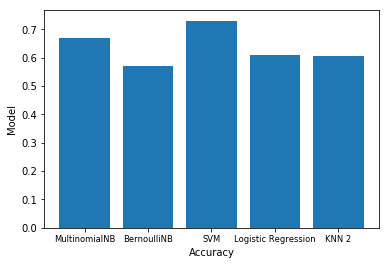

In [22]:
# Graph the accuracy of the tested models
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(range(len(models_xAxis)), accuracy_yAxis, align='center')
plt.xticks(range(len(models_xAxis)), models_xAxis, size='small')
plt.xlabel('Accuracy')
plt.ylabel('Model')